## Mask_Generator training ##

Here is the notebook to train the Mask_Generator network able to perform mask generation on CARE projected images. Once trained, it will predict a background pixel class and a foreground pixel class of the notum. The prediction step is done thanks to another notebook.

Firstly, we import all the functions we need. We will specify the GPU we wants to use in the last line. We have to check that the GPU is not already use to avoid memory issues.

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history

from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
BaseDir = '/run/media/sancere/DATA/Lucas_NextonCreated_npz/'
NPZdata = 'Masks_Generator_Mix2_onlyequalized'+ '.npz'

ModelDir ='/home/sancere/NextonDisk_1/Lucas_Model_to_use/Mask_Generator/'
ModelName = 'Masks_Generator_Mix2_onlyequalized'
TransferModelName = 'Masks_Generator_Mix_onlyequalized'


load_path = BaseDir + NPZdata 


In [4]:

(X,Y), (X_val,Y_val), axes = load_training_data(load_path, validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 149328
number of validation images:	 16592
image size (2D):		 (160, 160)
axes:				 SYXC
channels in / out:		 1 / 1


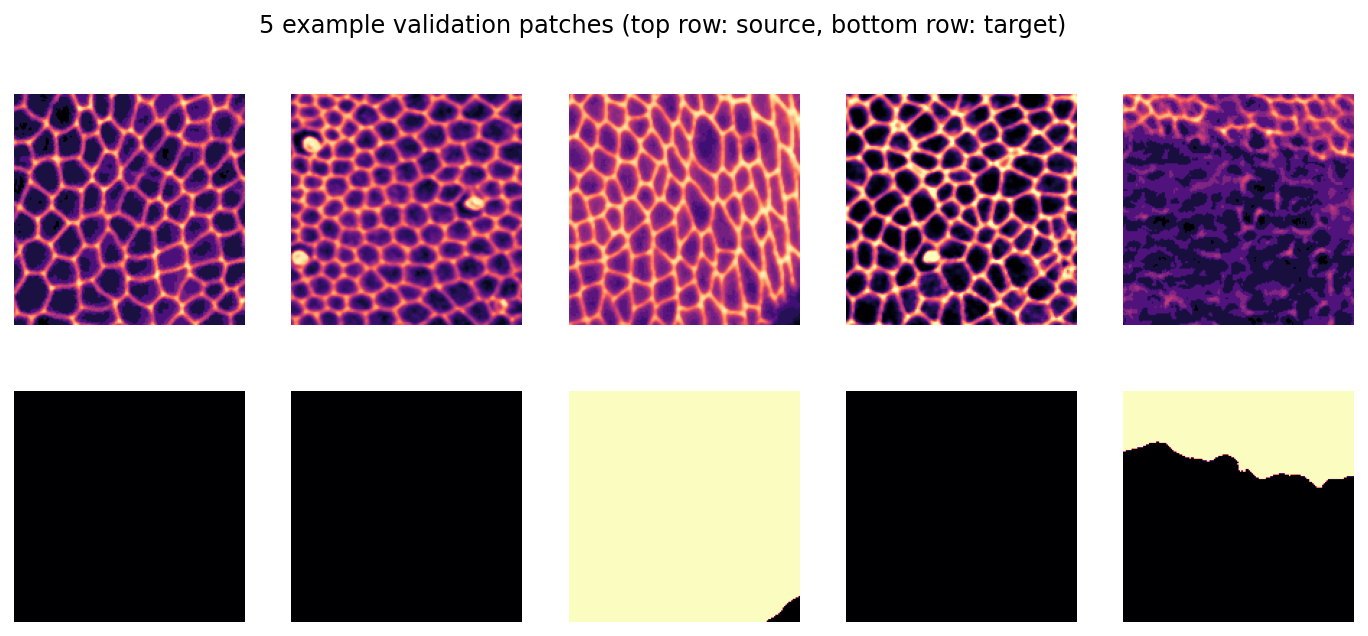

In [5]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

We define in the following cell the hyperparameters used for the training, number of epochs and number of steps per epochs. A config file recording all the parameters will be saved. 

In [6]:
config = Config(axes, n_channel_in, n_channel_out, probabilistic = False, unet_n_depth=5,unet_kern_size=7,train_epochs= 70, train_batch_size = 64, train_reduce_lr={'patience': 5, 'factor': 0.5})
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=64, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=70, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'patience': 5, 'factor': 0.5}, train_steps_per_epoch=400, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=7, unet_last_activation='linear', unet_n_depth=5, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 5,
 'unet_kern_size': 7,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 70,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 64,
 'train_tensorboard': True,
 'train_reduce_lr': {'patience': 5, 'factor': 0.5}}

Here we give to the model the hyperparameters, the name and the path where it will be saved.

**Primal:** `model.load_weights` allows to perform transfer learning, loading the h5 file from the given location.  

In [7]:
model = CARE(config = config, name = ModelName, basedir = ModelDir)
model.load_weights(ModelDir + TransferModelName + '/' + 'weights_best.h5')

In the next cell, we launch the training. 

In [8]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/70
400/400 [==============================] - 231s 576ms/step - loss: 0.0220 - mse: 0.0117 - mae: 0.0220 - val_loss: 0.0216 - val_mse: 0.0131 - val_mae: 0.0216 - lr: 4.0000e-04
Epoch 2/70
400/400 [==============================] - 227s 567ms/step - loss: 0.0197 - mse: 0.0114 - mae: 0.0197 - val_loss: 0.0174 - val_mse: 0.0110 - val_mae: 0.0174 - lr: 4.0000e-04
Epoch 3/70
400/400 [==============================] - 227s 568ms/step - loss: 0.0186 - mse: 0.0110 - mae: 0.0186 - val_loss: 0.0228 - val_mse: 0.0116 - val_mae: 0.0228 - lr: 4.0000e-04
Epoch 4/70
400/400 [==============================] - 225s 563ms/step - loss: 0.0192 - mse: 0.0110 - mae: 0.0192 - val_loss: 0.0155 - val_mse: 0.0111 - val_mae: 0.0155 - lr: 4.0000e-04
Epoch 5/70
400/400 [==============================] - 224s 561ms/step - loss: 0.0182 - mse: 0.0104 - mae: 0.0182 - val_loss: 0.0209 - val_mse: 0.0111 - val_mae: 0.0209 - lr: 4.0000e-04
Epoch 6/70
400/400 [==============================] - 227s 567ms/step - los

Then, we plot the loss curve of the training set and of the validation set to check that the training went well. (We can check if the training is finished, if there is overfitting etc - see https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


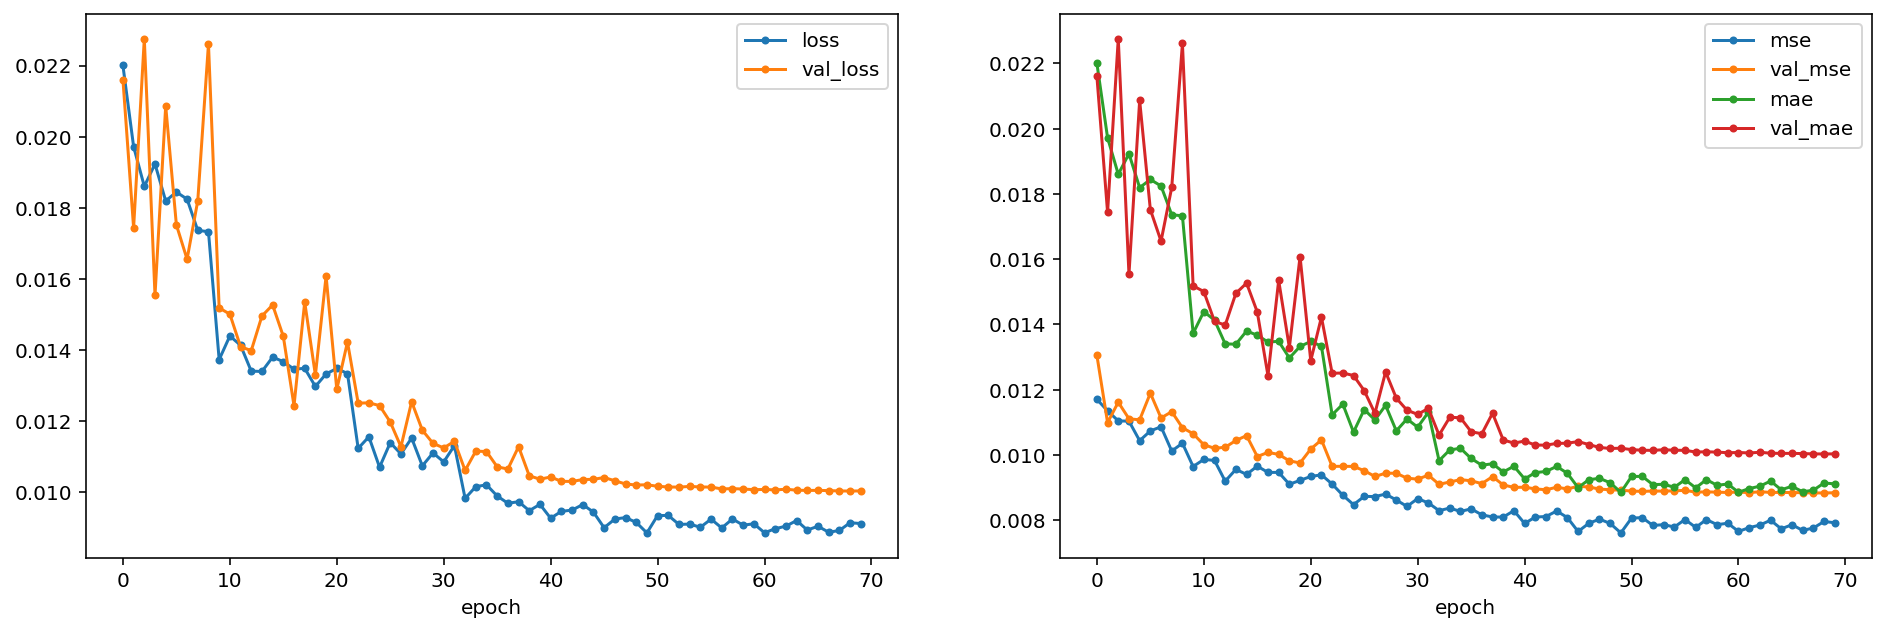

In [9]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

In the next cell we plot the patches of raw, groundtruth and predicted examples. You may have to scroll on the output view to see all the patches.

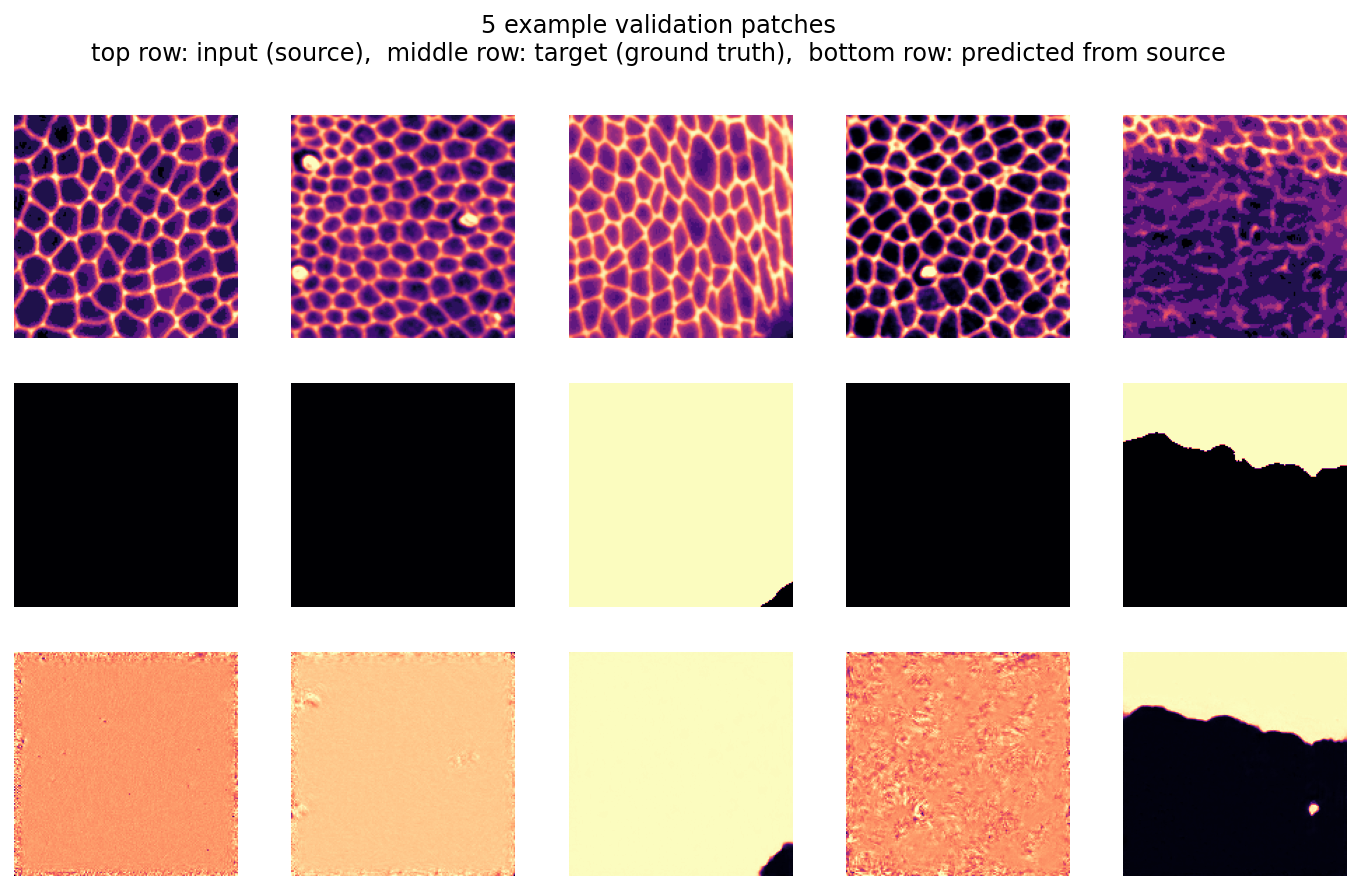

In [10]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

We then save the calculated weights.

In [11]:
model.export_TF()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp0_v1hjpy/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/sancere/NextonDisk_1/Lucas_Model_to_use/Mask_Generator/Masks_Generator_Mix2_onlyequalized/TF_SavedModel.zip
